# Détection de la pneumo

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


2025-06-16 22:01:12.575814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-16 22:01:12.858599: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Préparation des générateurs avec augmentation poussée

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './chest_Xray/train',
    target_size=(300, 400),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    './chest_Xray/val',
    target_size=(300, 400),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    './chest_Xray/test',
    target_size=(300, 400),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Calcul automatique des poids de classe (Normal vs Pneumonia)

In [3]:
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class weights :", class_weights)


Class weights : {0: 1.9448173005219984, 1: 0.6730322580645162}


## Modèle basé sur MobileNetV2 (Transfer Learning)

In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 400, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


2025-06-16 22:01:16.487183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 200, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 200, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Entraînement avec EarlyStopping

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/20
163/163 [==============================] - 214s 1s/step - loss: 0.7352 - accuracy: 0.5918 - val_loss: 0.6633 - val_accuracy: 0.5625
Epoch 2/20
163/163 [==============================] - 195s 1s/step - loss: 0.5928 - accuracy: 0.6787 - val_loss: 0.6087 - val_accuracy: 0.6875
Epoch 3/20
163/163 [==============================] - 192s 1s/step - loss: 0.5241 - accuracy: 0.7322 - val_loss: 0.5611 - val_accuracy: 0.7500
Epoch 4/20
163/163 [==============================] - 217s 1s/step - loss: 0.4548 - accuracy: 0.7910 - val_loss: 0.5313 - val_accuracy: 0.8125
Epoch 5/20
163/163 [==============================] - 208s 1s/step - loss: 0.4165 - accuracy: 0.8165 - val_loss: 0.5056 - val_accuracy: 0.8125
Epoch 6/20
163/163 [==============================] - 205s 1s/step - loss: 0.3848 - accuracy: 0.8340 - val_loss: 0.4852 - val_accuracy: 0.8125
Epoch 7/20
163/163 [==============================] - 206s 1s/step - loss: 0.3641 - accuracy: 0.8443 - val_loss: 0.4702 - val_accuracy: 0.8125

In [6]:
# Export du modèle entraîné
model.save("pneumonet_model.h5")
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model = load_model("pneumonet_model.h5")

## Courbes de précision et de perte

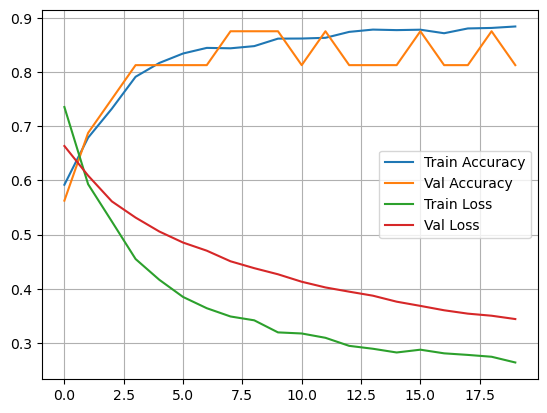

In [7]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.grid()
plt.show()

## Évaluation sur le jeu de test

In [8]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")
true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

print("Matrice de confusion :\n", cm)
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Specificity: {specificity:.2f}")


20/20 [==============================] - 16s 749ms/step
Matrice de confusion :
 [[196  38]
 [ 55 335]]
Sensitivity (Recall): 0.86
Precision: 0.90
Specificity: 0.84


20/20 [==============================] - 15s 715ms/step


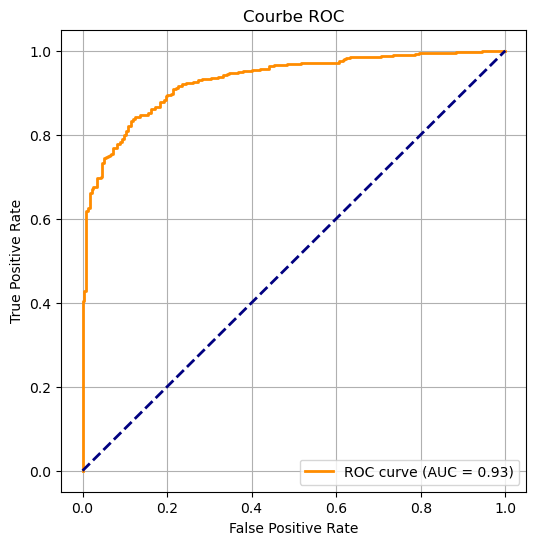

In [9]:
from sklearn.metrics import roc_curve, auc

# Prédire les probabilités
test_generator.reset()
y_probs = model.predict(test_generator)  # Probabilités continues
y_true = test_generator.classes           # Vraies classes binaires (0/1)

# Calculer les valeurs ROC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # ligne diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

# Charger le modèle sauvegardé
model = load_model("pneumonet_model.h5")

# Charger l'image à prédire
img_path = "./chest_Xray/test/PNEUMONIA/person1_virus_7.jpeg"  
img = load_img(img_path, target_size=(300, 400))  
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  

# Prédire
prediction = model.predict(img_array)
prob = float(prediction[0][0])  

# Appliquer un seuil pour obtenir 0 ou 1
predicted_class = int(prob > 0.5)

# Affichage
classe_humaine = "Pneumonia" if predicted_class == 1 else "Normal"

print(f"📷 Image : {img_path}")
print(f"🔢 Probabilité prédite : {prob:.2f}")
print(f"✅ Classe binaire : {predicted_class}")
print(f"🩺 Diagnostic : {classe_humaine}")



1/1 [==============================] - 0s 466ms/step
📷 Image : ./chest_Xray/test/PNEUMONIA/person1_virus_7.jpeg
🔢 Probabilité prédite : 0.95
✅ Classe binaire : 1
🩺 Diagnostic : Pneumonia


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda

# Créer un modèle qui inclut le prétraitement
def create_inference_model(trained_model):
    """
    Crée un modèle qui inclut le prétraitement (redimensionnement) des images
    
    Parameters:
    trained_model: Modèle Keras entraîné
    
    Returns:
    Un nouveau modèle qui accepte des images de n'importe quelle taille
    """
    # Définir une couche d'entrée qui accepte des images de n'importe quelle taille
    input_layer = Input(shape=(None, None, 3), name="image_input")
    
    def preprocess(x):
        x = tf.image.resize(x, (300, 400))
        x = x / 255.0
        return x
    
    preprocessed = Lambda(preprocess)(input_layer)
    
    # Obtenir les prédictions du modèle entraîné
    predictions = trained_model(preprocessed)
    
    # Créer un nouveau modèle
    inference_model = Model(inputs=input_layer, outputs=predictions)
    
    return inference_model

inference_model = create_inference_model(model)

# Tester le modèle d'inférence avec une image de taille quelconque
test_input = np.random.rand(1, 300, 400, 3)  # Taille arbitraire
result = inference_model.predict(test_input)
print(f"Test de prédiction réussi avec une image de taille arbitraire: {result.shape}")

1/1 [==============================] - 0s 391ms/step
Test de prédiction réussi avec une image de taille arbitraire: (1, 1)


In [12]:
import os
import tensorflow as tf
import numpy as np

def export_keras_to_tflite(model, sample_input=None, file_path="model.tflite", optimize=True):
    """
    Exporte un modèle Keras vers TensorFlow Lite
    
    Parameters:
    model: Modèle Keras compilé et entraîné
    sample_input: Exemple d'entrée (optionnel, pour la quantification)
    file_path: Chemin où sauvegarder le fichier TFLite
    optimize: Si True, applique les optimisations par défaut
    """
    
    # Créer le convertisseur TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # Appliquer les optimisations si demandé
    if optimize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Optionnel: Quantification avec données représentatives
    if sample_input is not None:
        def representative_dataset():
            for i in range(100):  # Utiliser 100 échantillons représentatifs
                yield [sample_input.astype(np.float32)]
        
        converter.representative_dataset = representative_dataset
        # Pour une quantification complète (optionnel)
        # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        # converter.inference_input_type = tf.uint8
        # converter.inference_output_type = tf.uint8
    
    try:
        # Convertir le modèle
        tflite_model = converter.convert()
        
        # Sauvegarder le modèle
        with open(file_path, 'wb') as f:
            f.write(tflite_model)
        
        print(f"Modèle exporté avec succès vers {file_path}")
        print(f"Taille du fichier: {os.path.getsize(file_path) / 1024:.2f} KB")
        
        # Tester le modèle TFLite
        test_tflite_model(file_path, sample_input)
        
    except Exception as e:
        print(f"Erreur lors de la conversion: {e}")

def test_tflite_model(tflite_path, sample_input):
    """
    Teste le modèle TensorFlow Lite converti
    """
    try:
        # Charger le modèle TFLite
        interpreter = tf.lite.Interpreter(model_path=tflite_path)
        interpreter.allocate_tensors()
        
        # Obtenir les détails des entrées et sorties
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        print("Détails du modèle TFLite:")
        print(f"  Forme d'entrée: {input_details[0]['shape']}")
        print(f"  Type d'entrée: {input_details[0]['dtype']}")
        print(f"  Forme de sortie: {output_details[0]['shape']}")
        print(f"  Type de sortie: {output_details[0]['dtype']}")
        
        # Tester avec l'échantillon d'entrée si fourni
        if sample_input is not None:
            interpreter.set_tensor(input_details[0]['index'], sample_input)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            print(f"  Test réussi! Forme de sortie: {output_data.shape}")
        
    except Exception as e:
        print(f"Erreur lors du test du modèle TFLite: {e}")

# Utilisation avec votre modèle
current_dir = os.getcwd()
output_path = os.path.join(current_dir, "pneumonia_model.tflite")

# Créer un échantillon d'entrée pour le test et l'optimisation
inference_sample = np.zeros((1, 300, 400, 3), dtype=np.float32)

# Exporter le modèle (remplacez 'inference_model' par le nom de votre modèle)
export_keras_to_tflite(inference_model, inference_sample, output_path)

INFO:tensorflow:Assets written to: /tmp/tmpvp20rmza/assets


INFO:tensorflow:Assets written to: /tmp/tmpvp20rmza/assets
/home/adk/anaconda3/envs/pneumonia_detection/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2025-06-16 23:16:11.056424: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-06-16 23:16:11.056456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-06-16 23:16:11.060684: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvp20rmza
2025-06-16 23:16:11.077299: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-06-16 23:16:11.077330: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvp20rmza
2025-06-16 23:16:11.127593: I tensorflow/

Modèle exporté avec succès vers /home/adk/Pneumonia_/pneumonia_model.tflite
Taille du fichier: 2644.30 KB
Détails du modèle TFLite:
  Forme d'entrée: [1 1 1 3]
  Type d'entrée: <class 'numpy.float32'>
  Forme de sortie: [1 1]
  Type de sortie: <class 'numpy.float32'>
Erreur lors du test du modèle TFLite: Cannot set tensor: Dimension mismatch. Got 300 but expected 1 for dimension 1 of input 0.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Cross-validation avec StratifiedKFold

In [13]:
import pandas as pd
from glob import glob
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def load_dataframes(base_dirs):
    files = []
    labels = []
    for base in base_dirs:
        for label in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(base, label)
            for fname in os.listdir(path):
                if fname.lower().endswith((".jpg",".jpeg",".png")):
                    files.append(os.path.join(path, fname))
                    labels.append(1 if label=='PNEUMONIA' else 0)
    return pd.DataFrame({'filename': files, 'label': labels})

data_df = load_dataframes(['./chest_Xray/train', './chest_Xray/val'])

In [14]:
def create_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(data_df['filename'], data_df['label']), 1):
    train_df = data_df.iloc[train_idx]
    val_df = data_df.iloc[val_idx]
    train_df = train_df.copy()
    val_df = val_df.copy()
    train_df["label"] = train_df["label"].astype(str)
    val_df["label"] = val_df["label"].astype(str)

    train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='label', target_size=(224,224), class_mode='binary', batch_size=32)
    val_gen = val_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='label', target_size=(224,224), class_mode='binary', batch_size=32, shuffle=False)

    labels_train = train_gen.classes
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train)
    class_weights = dict(enumerate(class_weights))

    model = create_model()
    history = model.fit(train_gen, validation_data=val_gen, epochs=20, class_weight=class_weights, callbacks=[early_stop])

    val_gen.reset()
    y_prob = model.predict(val_gen).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    y_true = val_gen.classes

    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    fold_results.append({'fold': fold, 'accuracy': acc, 'roc_auc': roc, 'confusion_matrix': cm})

results_df = pd.DataFrame(fold_results)
mean_acc = results_df['accuracy'].mean()
mean_roc = results_df['roc_auc'].mean()
print(results_df[['fold','accuracy','roc_auc']])
print('Moyenne - accuracy:', mean_acc, ' ROC-AUC:', mean_roc)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Epoch 1/20
131/131 [==============================] - 102s 764ms/step - loss: 0.8707 - accuracy: 0.5838 - val_loss: 0.5951 - val_accuracy: 0.7030
Epoch 2/20
131/131 [==============================] - 97s 738ms/step - loss: 0.6856 - accuracy: 0.6349 - val_loss: 0.5115 - val_accuracy: 0.7784
Epoch 3/20
131/131 [==============================] - 96s 730ms/step - loss: 0.5667 - accuracy: 0.7190 - val_loss: 0.4390 - val_accuracy: 0.8233
Epoch 4/20
131/131 [==============================] - 92s 702ms/step - loss: 0.4884 - accuracy: 0.7618 - val_loss: 0.4076 - val_accuracy: 0.8405
Epoch 5/20
131/131 [==============================] - 96s 734ms/step - loss: 0.4305 - accuracy: 0.7990 - val_loss: 0.3818 - val_accuracy: 0.8481
Epoch 6/20
131/131 [==============================] - 94s 720ms/step - loss: 0.3971 - accuracy: 0.8172 - val_loss: 0.3689 - val_accuracy: 0.8481
Epoch 7

## Baseline avec un simple train_test_split

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)
train_df["label"] = train_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='label', target_size=(224,224), class_mode='binary', batch_size=32)
test_gen = val_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='label', target_size=(224,224), class_mode='binary', batch_size=32, shuffle=False)

labels_train = train_gen.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = dict(enumerate(class_weights))

baseline_model = create_model()
baseline_model.fit(train_gen, validation_data=test_gen, epochs=20, class_weight=class_weights, callbacks=[early_stop])

test_gen.reset()
y_prob = baseline_model.predict(test_gen).ravel()
y_pred = (y_prob > 0.5).astype(int)
y_true = test_gen.classes

baseline_acc = accuracy_score(y_true, y_pred)
baseline_roc = roc_auc_score(y_true, y_prob)
baseline_cm = confusion_matrix(y_true, y_pred)

print('Baseline accuracy:', baseline_acc)
print('Baseline ROC-AUC:', baseline_roc)
print('Baseline confusion matrix:', baseline_cm)

## Résumé des résultats

In [ ]:
print('Cross-validation metrics:')
print(results_df[['fold','accuracy','roc_auc']])
print('Moyennes :', results_df['accuracy'].mean(), results_df['roc_auc'].mean())
print('Baseline metrics:')
print('Accuracy:', baseline_acc)
print('ROC-AUC:', baseline_roc)
print('Confusion matrix:', baseline_cm)